In [151]:
%reset

In [246]:
import torch.utils.data as data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler
import torch
import abc
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from typing import List
from sklearn.model_selection import KFold
import numpy as np
from sklearn.utils import class_weight

#### Set up criteria for classifying the data

In [247]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

In [248]:
COLUMNS_TO_DUMMY = [
    "HeatingType",
    "AptManageType",
    "HallwayType",
    "TimeToBusStop",
    "TimeToSubway",
    "SubwayStation",
]
OUTPUT_COLUMN = "SalePrice"

# Create a dataset class for classification

In [306]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self._prepare_data()
        self.headers = list(self.data.columns)
        self._to_tensor()
        self.size = self.data.shape[0]

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns

    def prepare_for_training(self) -> None:
        self.data = self.get_data_as_pandas()
        self._multiply_data()
        self.shuffle()
        self._to_tensor()

    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMNS_TO_DUMMY and column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(
                    self.data[column].values.reshape(-1, 1)
                )

    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMNS_TO_DUMMY)
        if self.scaler:
            self._scale_data()

    def _to_tensor(self) -> None:
        self.headers = list(self.data.columns)
        if OUTPUT_COLUMN in self.headers:
            self.label = torch.tensor(self.data.iloc[:,0].values, dtype=torch.float32)
            self.data = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)
        else:
            self.data = torch.tensor(self.data.values, dtype=torch.float32)
            self.label = None
        self.size = self.data.shape[0]

    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        df = pd.concat([labels, data], axis=1)
        df.columns = self.headers
        return df

    @abc.abstractmethod
    def _multiply_data(self) -> None:
        return

    
    def shuffle(self):
        self.data.sample(frac=1)

In [307]:
class HouseDatasetClassification(HouseDataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__(path_to_csv, scaler)
        print(self.label)
        if self.label is not None:
            self._classify_data()

    def _classify_data(self) -> None:
        self.label = torch.where(
            self.label > CRITERIUM_MAX_AVERAGE,
            torch.tensor(2),
            torch.where(
                (self.label > CRITERIUM_MAX_CHEAP)
                & (self.label <= CRITERIUM_MAX_AVERAGE),
                torch.tensor(1),
                torch.tensor(0),
            ),
        )

    def _multiply_data(self) -> None:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(self.data.iloc[:,1:], self.data[OUTPUT_COLUMN])
        self.data = pd.concat([y, x], axis=1)

In [258]:
train_path = "../data/split_train_data/train_data.csv"
val_path = "../data/split_train_data/val_data.csv"
scaler = StandardScaler()

In [259]:
train_dataset_classify = HouseDatasetClassification(train_path, scaler)
# train_dataset_classify.prepare_for_training()
train_dataset_classify_df = train_dataset_classify.get_data_as_pandas()
val_dataset_classify = HouseDatasetClassification(val_path, scaler)

tensor([ 75920., 260176., 389380.,  ..., 296460., 376106.,  73840.])
tensor([408849., 210619., 358407.,  ..., 247787., 287610., 172566.])


In [260]:
# Display the data

In [261]:
train_dataset_classify_df

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0,0.202324,-1.019485,0.641248,-0.571717,0.535631,-0.096317,-1.424494,0.480494,0.928305,...,2.021979,-0.199736,2.634323,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,-0.275562
1,1,0.432564,-0.245248,-0.400815,-0.886559,1.687585,2.379252,0.650023,1.751334,-0.232155,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,1.620489,-0.580833,-0.351607,-0.275562
2,2,1.353523,-0.124927,-0.661331,-0.064211,1.812055,0.522575,1.687281,1.751334,-1.102500,...,2.021979,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,3.628943
3,0,-1.294234,-1.009022,0.120216,0.053267,-1.411954,-0.405763,-0.127921,-1.213960,1.798650,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,1.721666,-0.351607,-0.275562
4,1,-1.179114,1.279685,1.683310,1.571086,-0.103802,0.522575,1.168652,-0.790347,1.218420,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,1.721666,-0.351607,-0.275562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,1,1.238403,-0.124927,1.032021,-0.463637,1.453289,0.213129,1.168652,1.327721,1.218420,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,1.721666,-0.351607,-0.275562
2759,1,0.317444,-0.124927,0.771505,0.283524,-0.103802,-0.405763,0.001736,-0.366733,-1.972845,...,-0.494565,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,2.844084,-0.275562
2760,1,0.432564,-0.124927,2.204341,1.716759,-0.133089,-0.405763,-0.127921,-0.790347,-0.232155,...,-0.494565,-0.199736,-0.379604,2.638662,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,-0.275562
2761,2,1.353523,-0.124927,-0.531073,-0.064211,1.812055,0.522575,1.687281,1.751334,-1.102500,...,2.021979,-0.199736,-0.379604,-0.378980,-0.153989,-0.130117,-0.617098,-0.580833,-0.351607,3.628943


In [262]:
train_dataset_classify_df.iloc[:, 0].value_counts()

SalePrice
1    2005
2     391
0     367
Name: count, dtype: int64

# Classification model

In [263]:
class HousingClassificationModel(nn.Module):
    def __init__(self, input_size: int, class_num: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32,  class_num)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        # x = self.bn2(x)
        x = self.fc3(x)
        return x

####  Prepare loaders and set batch size and k-fold

In [264]:
k_folds  = 5
batch_size = 32
kf = KFold(n_splits=k_folds)

In [265]:
train_dataset_classify.label

tensor([0, 1, 2,  ..., 1, 2, 0])

#### Set up the model, optimizer and loss function

In [266]:
model_classify = HousingClassificationModel(input_size=train_dataset_classify.data.shape[1], class_num=3)
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.0005)
loss_fn_classify = nn.CrossEntropyLoss(torch.tensor([1.55, 1, 2]))
mca = MulticlassAccuracy(num_classes=3, average=None)
validation_loader_classify = data.DataLoader(val_dataset_classify, batch_size=batch_size, shuffle=True)

# Train the model

In [267]:
EPOCHS_NUMBER = 150
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset_classify)):
    train_loader_classify = data.DataLoader(
        data.Subset(train_dataset_classify, train_idx), batch_size=batch_size
    )
    validation_loader_classify = data.DataLoader(
        data.Subset(train_dataset_classify, val_idx), batch_size=batch_size
    )
    train_losses, train_accuracies, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], [], []
    tqdm_progress = tqdm(range(EPOCHS_NUMBER))

    t_batch_num, v_batch_num = len(train_loader_classify), len(validation_loader_classify)

    for epoch in tqdm_progress:
        train_batch_loss_sum, val_batch_loss_sum = 0, 0
        train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
        train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0
    
        model_classify.train()
        for data_patch, label in train_loader_classify:
            model_output = model_classify(data_patch).squeeze()
            loss = loss_fn_classify(model_output, label.type(torch.LongTensor))
            loss.backward()
            optimizer.step()
            train_batch_loss_sum += loss.item()
            optimizer.zero_grad()
            train_batch_accuracy_sum += mca(torch.argmax(model_output, dim=1), label)
            train_batch_f1_score_sum += f1_score(torch.argmax(model_output, dim=1), label, average="micro")
    
        train_batch_loss_avg = train_batch_loss_sum / t_batch_num
        train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num
        train_batch_f1_score_avg = train_batch_f1_score_sum / t_batch_num
    
        train_losses.append(train_batch_loss_avg)
        train_accuracies.append(train_batch_accuracy_avg)
        train_f1_scores.append(train_batch_f1_score_avg)
        
        model_classify.eval()
        for val_inputs, val_labels in validation_loader_classify:
            val_predicts = model_classify(val_inputs).squeeze(dim=1)
            val_loss = loss_fn_classify(val_predicts, val_labels.type(torch.LongTensor))
            val_batch_loss_sum += val_loss.item()
            val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)
            val_batch_f1_score_sum += f1_score(
                torch.argmax(val_predicts, dim=1), val_labels, average="micro"
            )
        val_batch_loss_avg = val_batch_loss_sum / v_batch_num
        val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num
        val_batch_f1_score_avg = val_batch_f1_score_sum / v_batch_num
        
        val_accuracies.append(val_batch_accuracy_avg)
        val_losses.append(val_batch_loss_avg)
        val_f1_scores.append(val_batch_f1_score_avg)
        
        tqdm_progress.set_postfix(
            {
                "Epoch": epoch + 1,
                "Los in train": {train_batch_loss_avg},
                "Loss in eval": {val_batch_loss_avg},
                "f1 in train": {train_batch_f1_score_avg},
                "f1 in eval": {val_batch_f1_score_avg},
            }
        )

100%|██████████| 150/150 [00:25<00:00,  5.93it/s, Epoch=150, Los in train={0.24600855112075806}, Loss in eval={0.31504591057697934}, f1 in train={0.8816964285714286}, f1 in eval={0.8454861111111112}]


In [268]:
with torch.no_grad():
    predicts_train = model_classify(train_dataset_classify.data.clone().detach())
    predicts_test = model_classify(val_dataset_classify.data.clone().detach())
    predicted_argmax_train = torch.argmax(predicts_train, dim=1)
    predicted_argmax_test = torch.argmax(predicts_test, dim=1)

In [269]:
val_accuracies

[tensor([0.9778, 0.8455, 0.8797]),
 tensor([0.9639, 0.8340, 0.8876]),
 tensor([0.9639, 0.8367, 0.8797]),
 tensor([0.9750, 0.8482, 0.8642]),
 tensor([0.9438, 0.8456, 0.8642]),
 tensor([0.9549, 0.8275, 0.8828]),
 tensor([0.9750, 0.8271, 0.8735]),
 tensor([0.9750, 0.8320, 0.8735]),
 tensor([0.9688, 0.8247, 0.8828]),
 tensor([0.9688, 0.8320, 0.8735]),
 tensor([0.9750, 0.8348, 0.8735]),
 tensor([0.9549, 0.8327, 0.8735]),
 tensor([0.9549, 0.8348, 0.8735]),
 tensor([0.9438, 0.8371, 0.8735]),
 tensor([0.9549, 0.8320, 0.8735]),
 tensor([0.9750, 0.8344, 0.8735]),
 tensor([0.9750, 0.8320, 0.8735]),
 tensor([0.9549, 0.8320, 0.8735]),
 tensor([0.9750, 0.8273, 0.8735]),
 tensor([0.9750, 0.8271, 0.8735]),
 tensor([0.9549, 0.8271, 0.8797]),
 tensor([0.9549, 0.8198, 0.8889]),
 tensor([0.9488, 0.8299, 0.8797]),
 tensor([0.9750, 0.8223, 0.8735]),
 tensor([0.9889, 0.8271, 0.8797]),
 tensor([0.9750, 0.8173, 0.8797]),
 tensor([0.9688, 0.8245, 0.8797]),
 tensor([0.9750, 0.8271, 0.8797]),
 tensor([0.9750, 0.8

Text(0, 0.5, 'Accuracy')

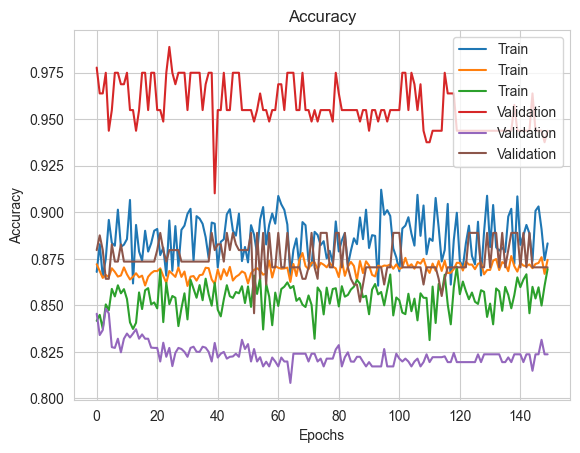

In [270]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'F1 score')

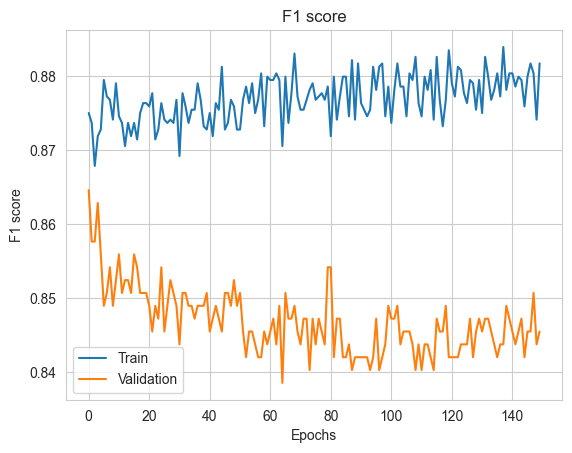

In [271]:
plt.plot(train_f1_scores, label="Train")
plt.plot(val_f1_scores, label="Validation")
plt.legend()
plt.title("F1 score")
plt.xlabel("Epochs")
plt.ylabel("F1 score")

In [272]:
val_f1_scores

[0.8645833333333334,
 0.8576388888888888,
 0.8576388888888888,
 0.8628472222222222,
 0.8559027777777778,
 0.8489583333333334,
 0.8506944444444444,
 0.8541666666666666,
 0.8489583333333334,
 0.8524305555555556,
 0.8559027777777778,
 0.8506944444444444,
 0.8524305555555556,
 0.8524305555555556,
 0.8506944444444444,
 0.8559027777777778,
 0.8541666666666666,
 0.8506944444444444,
 0.8506944444444444,
 0.8506944444444444,
 0.8489583333333334,
 0.8454861111111112,
 0.8489583333333334,
 0.8472222222222222,
 0.8541666666666666,
 0.8454861111111112,
 0.8489583333333334,
 0.8524305555555556,
 0.8506944444444444,
 0.8489583333333334,
 0.84375,
 0.8506944444444444,
 0.8506944444444444,
 0.8489583333333334,
 0.8489583333333334,
 0.8472222222222222,
 0.8489583333333334,
 0.8489583333333334,
 0.8489583333333334,
 0.8506944444444444,
 0.8454861111111112,
 0.8472222222222222,
 0.8489583333333334,
 0.8472222222222222,
 0.8454861111111112,
 0.8506944444444444,
 0.8506944444444444,
 0.8489583333333334,
 0.

In [273]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

Text(0, 0.5, 'Accuracy mean')

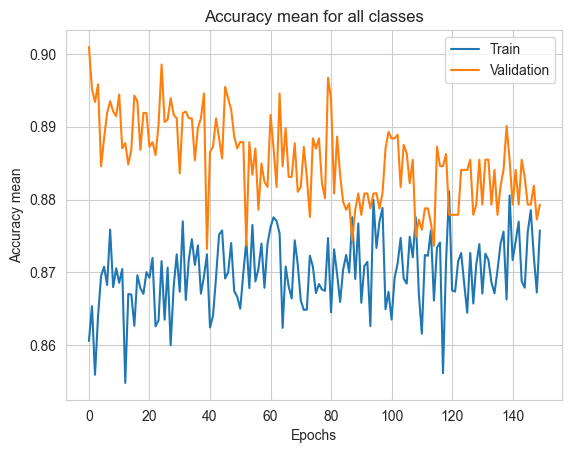

In [274]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()
plt.title("Accuracy mean for all classes")
plt.xlabel("Epochs")
plt.ylabel("Accuracy mean")

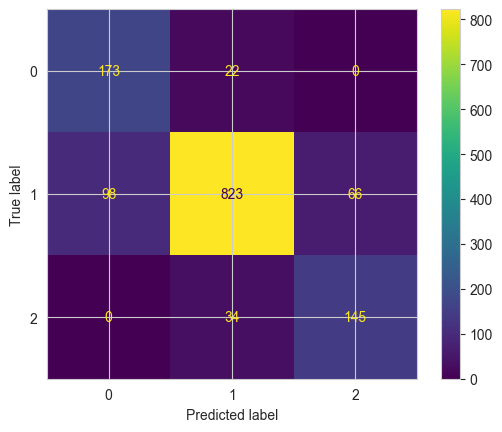

In [275]:
conf_matrix_test= confusion_matrix(val_dataset_classify.label, predicted_argmax_test)
ConfusionMatrixDisplay(conf_matrix_test).plot()
plt.show()

In [276]:
f1_score(predicted_argmax_test, val_dataset_classify.label,average="micro")

0.8383541513592946

In [277]:
mca(predicted_argmax_test, val_dataset_classify.label)

tensor([0.8872, 0.8338, 0.8101])

In [278]:
mca(predicted_argmax_train, train_dataset_classify.label)

tensor([0.9373, 0.8673, 0.8696])

In [279]:
# torch.save(model_classify.state_dict(), "../models/classification_model.pth")

In [280]:
# torch.save(model_classify.state_dict(), "../models/classification_model_with_cv.pth")

In [281]:
# torch.save(model_classify.state_dict(), "../final_models/classification_model_with_cv_and_f1-talk.pth")

# Final Training

In [282]:
whole_dataset_classify = HouseDatasetClassification("../data/train_data.csv", scaler)
whole_loader_classify = data.DataLoader(whole_dataset_classify, batch_size=batch_size, shuffle=True)

tensor([141592.,  51327.,  48672.,  ..., 357522., 312389., 393805.])


In [283]:
k_folds  = 10
batch_size = 64
kf = KFold(n_splits=k_folds)

In [284]:
model_classify = HousingClassificationModel(input_size=whole_dataset_classify.data.shape[1], class_num=3)
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.0005)
loss_fn_classify = nn.CrossEntropyLoss(torch.tensor([1.55, 1, 2]))
mca = MulticlassAccuracy(num_classes=3, average=None)

In [285]:
EPOCHS_NUMBER = 150
for fold, (train_idx, val_idx) in enumerate(kf.split(whole_dataset_classify)):
    train_loader_classify = data.DataLoader(
        data.Subset(whole_dataset_classify, train_idx), batch_size=batch_size
    )
    validation_loader_classify = data.DataLoader(
        data.Subset(whole_dataset_classify, val_idx), batch_size=batch_size
    )
    train_losses, train_accuracies, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], [], []
    tqdm_progress = tqdm(range(EPOCHS_NUMBER))

    t_batch_num, v_batch_num = len(train_loader_classify), len(validation_loader_classify)

    for epoch in tqdm_progress:
        train_batch_loss_sum, val_batch_loss_sum = 0, 0
        train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
        train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

        model_classify.train()
        for data_patch, label in train_loader_classify:
            model_output = model_classify(data_patch).squeeze()
            loss = loss_fn_classify(model_output, label.type(torch.LongTensor))
            loss.backward()
            optimizer.step()
            train_batch_loss_sum += loss.item()
            optimizer.zero_grad()
            train_batch_accuracy_sum += mca(torch.argmax(model_output, dim=1), label)
            train_batch_f1_score_sum += f1_score(torch.argmax(model_output, dim=1), label, average="micro")

        train_batch_loss_avg = train_batch_loss_sum / t_batch_num
        train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num
        train_batch_f1_score_avg = train_batch_f1_score_sum / t_batch_num

        train_losses.append(train_batch_loss_avg)
        train_accuracies.append(train_batch_accuracy_avg)
        train_f1_scores.append(train_batch_f1_score_avg)

        model_classify.eval()
        for val_inputs, val_labels in validation_loader_classify:
            val_predicts = model_classify(val_inputs).squeeze(dim=1)
            val_loss = loss_fn_classify(val_predicts, val_labels.type(torch.LongTensor))
            val_batch_loss_sum += val_loss.item()
            val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)
            val_batch_f1_score_sum += f1_score(
                torch.argmax(val_predicts, dim=1), val_labels, average="micro"
            )
        val_batch_loss_avg = val_batch_loss_sum / v_batch_num
        val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num
        val_batch_f1_score_avg = val_batch_f1_score_sum / v_batch_num

        val_accuracies.append(val_batch_accuracy_avg)
        val_losses.append(val_batch_loss_avg)
        val_f1_scores.append(val_batch_f1_score_avg)

        tqdm_progress.set_postfix(
            {
                "Epoch": epoch + 1,
                "Los in train": {train_batch_loss_avg},
                "Loss in eval": {val_batch_loss_avg},
                "f1 in train": {train_batch_f1_score_avg},
                "f1 in eval": {val_batch_f1_score_avg},
            }
        )

100%|██████████| 150/150 [00:20<00:00,  7.16it/s, Epoch=150, Los in train={0.25764511956769076}, Loss in eval={0.6017083440508161}, f1 in train={0.8696120689655172}, f1 in eval={0.7908163265306122}]


In [286]:
with torch.no_grad():
    predicts_whole = model_classify(whole_dataset_classify.data.clone().detach())
    predicted_argmax_whole = torch.argmax(predicts_whole, dim=1)

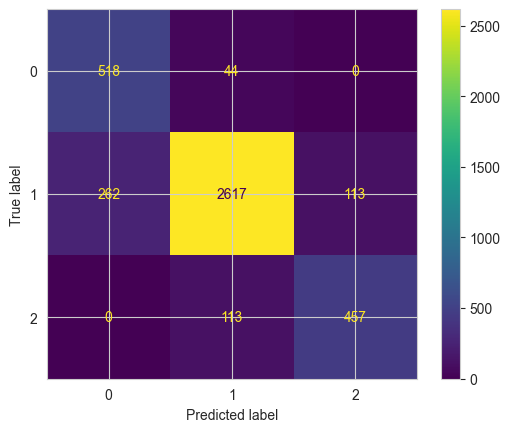

In [287]:
conf_matrix_whole= confusion_matrix(whole_dataset_classify.label, predicted_argmax_whole)
ConfusionMatrixDisplay(conf_matrix_whole).plot()
plt.show()

In [288]:
f1_score(predicted_argmax_whole, whole_dataset_classify.label,average="micro")

0.8709990300678953

In [289]:
mca(predicted_argmax_whole, whole_dataset_classify.label)

tensor([0.9217, 0.8747, 0.8018])

In [290]:
torch.save(model_classify.state_dict(), "../final_models_whole_dataset/classification_model_with_cv.pth")

# Load the model

In [291]:
model_classify = HousingClassificationModel(input_size=whole_dataset_classify.data.shape[1], class_num=3)
model_classify.load_state_dict(torch.load("../final_models/classification_model_with_cv_and_f1-talk.pth"))

<All keys matched successfully>

In [292]:
with torch.no_grad():
    predicts_whole = model_classify(whole_dataset_classify.data.clone().detach())
    predicted_argmax_whole = torch.argmax(predicts_whole, dim=1)

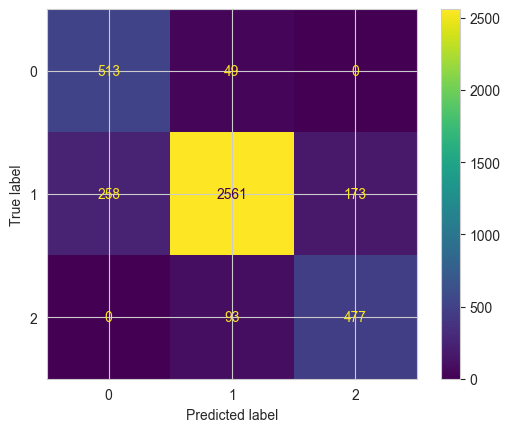

In [293]:
conf_matrix_whole= confusion_matrix(whole_dataset_classify.label, predicted_argmax_whole)
ConfusionMatrixDisplay(conf_matrix_whole).plot()
plt.show()

In [294]:
f1_score(predicted_argmax_whole, whole_dataset_classify.label,average="micro")

0.8610572259941804

In [295]:
mca(predicted_argmax_whole, whole_dataset_classify.label)

tensor([0.9128, 0.8559, 0.8368])

# Train and save csv - final_models

In [299]:
test_dataset = HouseDatasetClassification("../data/test_data.csv", scaler)

None


In [300]:
with torch.no_grad():
    predicts_test = model_classify(test_dataset.data.clone().detach())
    predicted_argmax_test = torch.argmax(predicts_test, dim=1)

In [301]:
numpy_data = predicted_argmax_test.numpy()
np.savetxt("../final_predictions/classification_data_cv.csv", numpy_data, delimiter=",")

# Train and save csv - final_models_whole_dataset

In [311]:
model_classify_whole = HousingClassificationModel(input_size=whole_dataset_classify.data.shape[1], class_num=3)
model_classify_whole.load_state_dict(torch.load("../final_models_whole_dataset/classification_model_with_cv.pth"))

<All keys matched successfully>

In [312]:
with torch.no_grad():
    predicts_test_whole = model_classify(test_dataset.data.clone().detach())
    predicted_argmax_test_whole = torch.argmax(predicts_test, dim=1)

In [313]:
numpy_data_whole = predicted_argmax_test_whole.numpy()
np.savetxt("../final_predictions/classification_data_cv_whole.csv", numpy_data_whole, delimiter=",")